# Autencoder
This notebook implements common autoencoders using pytorch. The training dataset is MNIST.

The types of autoencoders on this notebook are as follows:
1. Basic AE
2. Conv AE
3. Denoising AE
4. Variational AE

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

batch_size = 64

# Download training and test data from open datasets.
training_data = datasets.MNIST(root="./datasets", train=True, transform=ToTensor(), download=True)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

test_data = datasets.MNIST(root="./datasets", train=False, transform=ToTensor(), download=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

dataiter = iter(train_dataloader)
img, lbl = next(dataiter)
print(torch.min(img), torch.max(img))

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")



tensor(0.) tensor(1.)
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Using cuda device


## Basic Autoencoder

In [2]:
# Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )
        
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [3]:
model = Autoencoder().to(device)
print(model)
loss_fn  = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay = 1e-8)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


In [21]:
epochs = 10
outputs = []
for epoch in range(epochs):
    for (img, _) in train_dataloader:
        img = img.to(device)
        img = img.reshape(-1,28*28)
        recon = model(img)
        loss = loss_fn(recon, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}, Loss:{loss.item():.4f}")
    outputs.append((epoch, img, recon))


Epoch 1, Loss:0.0127
Epoch 2, Loss:0.0151
Epoch 3, Loss:0.0170
Epoch 4, Loss:0.0157
Epoch 5, Loss:0.0151
Epoch 6, Loss:0.0161
Epoch 7, Loss:0.0153
Epoch 8, Loss:0.0161
Epoch 9, Loss:0.0155
Epoch 10, Loss:0.0154


Epoch: 0
Epoch: 4
Epoch: 8


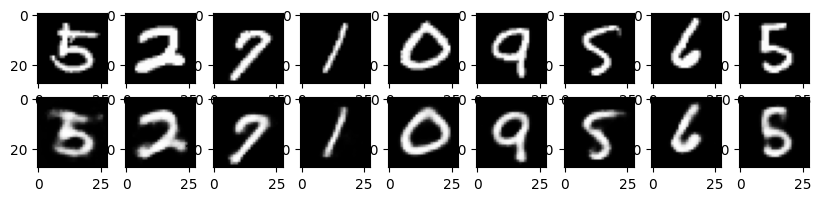

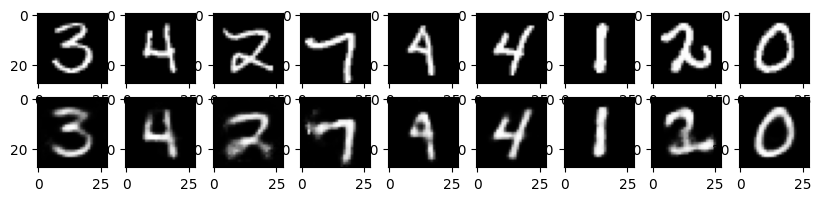

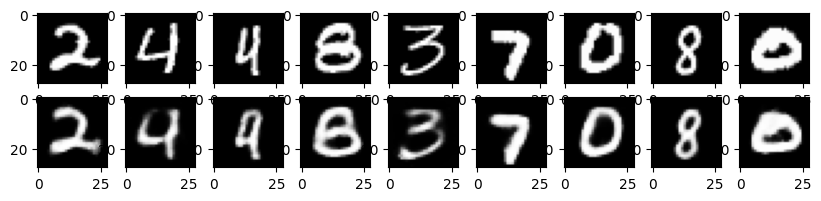

In [22]:
for k in range(0, epochs, 4):
    print(f"Epoch: {k}")
    plt.figure(figsize=(10,2))
    plt.gray()
    imgs = outputs[k][1].cpu().detach().numpy()
    recons = outputs[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])

    for i, item in enumerate(recons):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])

RuntimeError: shape '[8, 8]' is invalid for input of size 25088

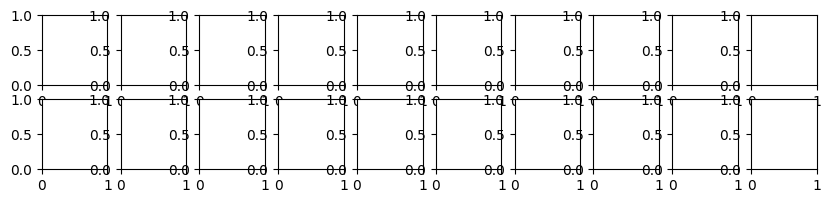

In [15]:
# Visualize original and reconstructed images
fig, axs = plt.subplots(2, 10, figsize=(10, 2))
with torch.no_grad():
    for i in range(10):
        axs[0, i].imshow(outputs[i][1].view(8, 8), cmap='gray')
        axs[1, i].imshow(model(data[i]).view(8, 8), cmap='gray')
plt.show()

In [11]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        X = X.reshape(-1,28*28)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            X = X.reshape(-1,28*28)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    # test(test_dataloader, model, loss_fn)
print("Done!")

# # Training loop
# epochs = 1
# for epoch in range(epochs):
#     output = model(train_dataloader)
#     loss = criterion(output, train_dataloader)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

# # Visualize original and reconstructed images
# fig, axs = plt.subplots(2, 10, figsize=(10, 2))
# with torch.no_grad():
#     for i in range(10):
#         axs[0, i].imshow(data[i].view(8, 8), cmap='gray')
#         axs[1, i].imshow(model(data[i]).view(8, 8), cmap='gray')
# plt.show()

Epoch 1
-------------------------------


/home/peka/prototypes/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 784])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (784) must match the size of tensor b (64) at non-singleton dimension 1